In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def ver_imag(path):
  img = mpimg.imread(path)  # Cambia el nombre si es necesario
  plt.imshow(img)
  plt.axis('off')  # Oculta los ejes
  plt.show()


# Construyendo un chatbot básico
Hablamos sobre los chatbots como una de las aplicaciones más importantes del mundo real en el procesamiento del lenguaje natural (NLP).  Tenemos las suficientes bases  para crear un chatbot básico que pueda ser entrenado con un corpus predefinido y proporcionar respuestas a consultas utilizando conceptos de similitud.

El requisito más importante para construir un chatbot es el corpus o conjunto de datos textuales en el que se entrenará. El corpus debe ser relevante y exhaustivo. Por ejemplo, si estás construyendo un chatbot para el departamento de Recursos Humanos (RH) de tu organización, necesitarías un corpus que contenga todas las políticas de RH para entrenar el bot, y no un corpus con discursos presidenciales. También es necesario garantizar que el tiempo de respuesta sea aceptable y que el bot no tome demasiado tiempo en responder. Idealmente, el bot debería parecer humano y alcanzar un nivel de precisión adecuado.

Para el chatbot que crearemos se usaran los datos de preguntas y respuestas de Amazon, que es un repositorio de preguntas y respuestas recopiladas del sitio web de Amazon para varias categorías de productos (http://jmcauley.ucsd.edu/data/amazon/qa/). Dado que el conjunto de datos es masivo, solo se usaran los datos de preguntas y respuestas relacionados con artículos electrónicos. Al estar entrenado con estos datos, nuestro chatbot podría implementarse como soporte automatizado de preguntas y respuestas en la sección de artículos electrónicos.

In [ ]:
from google.colab import files
import zipfile
import json

# Subir archivo ZIP
uploaded = files.upload()



Saving qa_Electronics.zip to qa_Electronics (1).zip


In [ ]:
import zipfile

# Nombre del archivo ZIP ya cargado
zip_path = "/content/qa_Electronics.zip"

# Listar y extraer los archivos
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Lista los archivos dentro del ZIP
    archivos = zip_ref.namelist()
    print("Archivos en el ZIP:", archivos)

    # Extraer todos los archivos en el directorio actual
    zip_ref.extractall()
    print("Archivos extraídos en el directorio actual.")


Archivos en el ZIP: ['qa_Electronics.json']
Archivos extraídos en el directorio actual.


In [ ]:
import ast
questions = []
answers = []
with open('qa_Electronics.json','r') as f:
 for line in f:
  data = ast.literal_eval(line)
  questions.append(data['question'].lower())
  answers.append(data['answer'].lower())


In [ ]:
import pandas as pd

# Create a DataFrame
df_Text_analisis = pd.DataFrame({'questions': questions, 'answers': answers})

# Now you can work with 'df' which contains your data
print(df.head())  # Display the first few rows to verify

                                           questions  \
0  is this cover the one that fits the old nook c...   
1                        does it fit nook glowlight?   
2     would it fit nook 1st edition? 4.9in x 7.7in ?   
3           will this fit a nook color that's 5 x 8?   
4   will this fit the samsung galaxy tab 4 nook 10.1   

                                             answers  
0  yes this fits both the nook color and the same...  
1                 no. the nook color or color tablet  
2  i don't think so. the nook color is 5 x 8 so n...  
3                                                yes  
4            no, the tab is smaller than the 'color'  


Como se observa, cada fila de datos está en un formato de diccionario con varios pares llave-valor. Ahora que estamos familiarizados con el corpus, diseñemos la arquitectura del chatbot de la siguiente manera:

Almacenar todas las preguntas del corpus en una lista.
Almacenar todas las respuestas correspondientes del corpus en otra lista.
Vectorizar y preprocesar los datos de las preguntas (convertir el texto en representaciones numéricas que puedan ser procesadas por algoritmos).
Vectorizar y preprocesar la consulta del usuario.
Evaluar cuál es la pregunta más similar a la consulta del usuario utilizando la similitud de coseno (una métrica que mide cómo de similares son dos vectores en un espacio multidimensional).
Devolver la respuesta correspondiente a la pregunta más similar como respuesta del chatbot.

Durante la importación, también realizamos el paso de preprocesamiento convirtiendo todos los caracteres a minúsculas. Luego, utilizando el módulo CountVectorizer de la biblioteca sklearn, convertimos la lista de preguntas en una matriz dispersa y aplicamos la transformación TF-IDF (Term Frequency-Inverse Document Frequency),

In [ ]:
import re

def clean_data(df_Text_analisis):

    # Asegurar que no hay valores NaN
    df_Text_analisis['questions'] = df_Text_analisis['questions'].fillna('')

    # Decodificar las entidades HTML
    df_Text_analisis['questions'] = df_Text_analisis['questions'].apply(html.unescape)

    # Convertir el texto a minúsculas.
    df_Text_analisis['Text'] = df_Text_analisis['Text'].str.lower()

    # Reducir letras repetidas
    df_Text_analisis['Text'] = df_Text_analisis['Text'].apply(lambda x: re.sub(r'(.)\1{2,}', r'\1\1', x))

    # Eliminar palabras repetidas
    df_Text_analisis['Text'] = df_Text_analisis['Text'].apply(lambda x: re.sub(r'\b(\w+)( \1\b)+', r'\1', x))

    # Eliminar menciones en la columna 'Text'
    df_Text_analisis['Text'] = df_Text_analisis['Text'].apply(lambda x: re.sub(r'@\w+', '', x))

    # # Eliminar URLs
    df_Text_analisis['Text'] = df_Text_analisis['Text'].apply(lambda x: re.sub(r'http\S+|www\.\S+', '', x))

    # Eliminar puntuación
    df_Text_analisis['Text'] = df_Text_analisis['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

    # Eliminar números
    df_Text_analisis['Text'] = df_Text_analisis['Text'].apply(lambda x: re.sub(r'\d+', '', x))

    # Reemplazar caracteres no alfanuméricos con un espacio
    df_Text_analisis['Text'] = df_Text_analisis['Text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', ' ', x))

    # Eliminar espacios en blanco adicionales
    df_Text_analisis['Text'] = df_Text_analisis['Text'].apply(lambda x: re.sub(r'\s+', ' ', x))

    # Corregir ortografía
    #df_Text_analisis['Text'] = df_Text_analisis['Text'].apply(lambda x: str(TextBlob(x).correct()))

    # Retornar DataFrame limpio
    return df_Text_analisis

df_Text_analisis_clean = clean_data(df_Text_analisis['questions'].copy())
df_Text_analisis_clean.head()

KeyError: 'Text'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer="word", ngram_range=(1, 2), max_features=50000)
que_tfidf = vectorizer.fit_transform(df['questions'])


In [ ]:
que_tfidf.shape

(314263, 793476)

La matriz X_tfidf es el repositorio que se buscará cada vez que se ingrese una nueva pregunta en el chatbot para encontrar la pregunta más similar. Para implementar esto, creamos una función que calcula el ángulo entre cada fila de la matriz X_tfidf y el vector de la nueva pregunta. Utilizamos el módulo cosine_similarity de la biblioteca sklearn para calcular el coseno entre cada fila y el vector, y luego convertimos el coseno en grados.

Finalmente, buscamos la fila que tiene el coseno máximo (o el ángulo mínimo) con el vector de la nueva pregunta y devolvemos la respuesta correspondiente a esa pregunta como respuesta del chatbot. Si el ángulo más pequeño entre el vector de la pregunta y cada fila de la matriz es mayor que un valor de umbral, consideramos que esa pregunta es lo suficientemente diferente como para no justificar una respuesta.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


## CNN

Las relaciones entre las palabras pueden derivarse observando su posición relativa entre sí. Estas relaciones pueden interpretarse como una serie temporal en la que las palabras habladas constituyen una base de datos de series temporales. Por otro lado, también podemos analizar sus posiciones relativas y derivar relaciones a partir de estas. Estas aproximaciones son utilizadas por formas más complejas y modernas de Redes Neuronales Artificiales (ANNs), conocidas como Redes Neuronales Convolucionales (CNNs) y Redes Neuronales Recurrentes (RNNs).

## Entendiendo las convoluciones
Las imágenes se describen mediante píxeles. Estos píxeles pueden tener valores variables, dependiendo de si la imagen es en blanco y negro, en escala de grises o a color. Los valores de los píxeles reflejan los patrones que podrían estar representando. Como parte de la convolución, intentamos deslizar (realizar un producto punto) lo que llamamos filtros a lo largo de la imagen para capturar patrones a partir de los píxeles.
<img src="https://drive.google.com/file/d/18jdHuPKqPRaHkL5SOo43OFejXh55x3ai/view?usp=drive_link" alt="Descripción de la imagen" width="400">

![Imagen desde Drive](/content/drive/MyDrive/imagenes/imagen1.png)





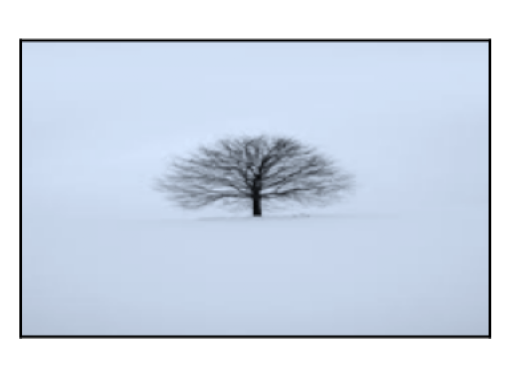

In [ ]:
ver_imag("/content/imagen 1.png")


Supongamos que la imagen anterior puede representarse mediante la siguiente matriz de píxeles de 4 x 4, donde cada valor indica la intensidad de ese píxel en la imagen:



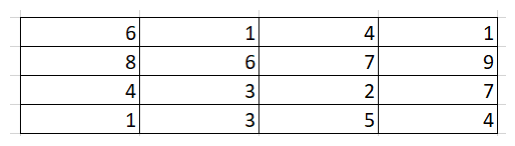

In [ ]:
ver_imag("/content/imagen2.png")

Podemos aplicar el siguiente filtro a la imagen:

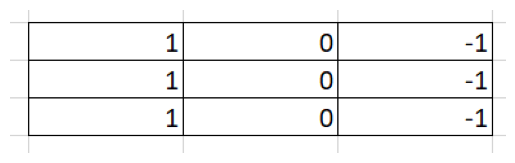

In [ ]:
ver_imag("/content/imagen3.png")

Ahora, utilizando este filtro, queremos encontrar el patrón especificado en el filtro a lo largo de la imagen. Lo que podemos hacer aquí es realizar una multiplicación elemento a elemento, que no es más que un producto punto aplicado a la imagen. Los resultados de la multiplicación elemento a elemento se suman en cada pasada del filtro sobre la imagen. Al hacer esto, obtenemos la matriz resultante, que muestra la intensidad del patrón o filtro en varios puntos de la imagen. La siguiente matriz se obtiene después de aplicar el filtro a la imagen:

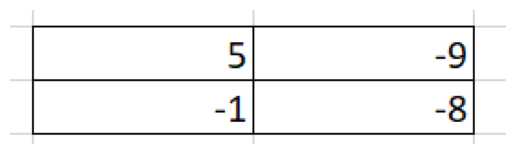

In [ ]:
ver_imag("/content/imagen4.png")

Tomemos el valor 5 de la matriz de salida y comprendamos cómo lo obtuvimos.
Realizamos una multiplicación elemento a elemento entre las entradas desde (1, 1) hasta (3, 3) en la matriz de entrada. Este filtro se ve de la siguiente manera:
$(6*1) + (1*0) + (4*-1) + (8*1) + (6*0) + (7*-1) + (4*1) + (3*0) + (2*-1) = 5$

De manera similar, obtenemos los demás valores. Aquí asumimos que la matriz estaba indexada comenzando desde 1.
Estos valores luego se pasan a través de funciones de activación, que pueden considerarse como parte del filtro junto con los pesos.
El proceso que describimos aquí es principalmente lo que ocurre en la capa convolucional. Cada capa convolucional puede tener múltiples filtros, también conocidos como kernels. Los valores en estos filtros son pesos que la red actualiza para ajustar esos patrones a los datos. En el ejemplo que discutimos, utilizamos un filtro de tamaño 3 x 3. Estos filtros también pueden tener diferentes dimensiones.
Existe una fórmula sencilla que rige lo que hemos discutido aquí.
Si tenemos una imagen de tamaño

$n×n$ y un filtro de tamaño

$f×f$, entonces la salida será una matriz con las siguientes dimensiones:
$$(n-f+1)*(n-f+1)$$

## Añadamos relleno a nuestros datos
Lo que esencialmente hacemos es utilizar una técnica llamada relleno (padding), que consiste en agregar entradas pseudocontenidas que contienen 0s como valores al final. Esto se conoce como relleno con ceros (zero-padding), y como resultado, los valores hacia los bordes también pueden ser percibidos como internos en la matriz. Ningún valor es submuestreado en comparación con los demás. Además, esto permite que el filtro encuentre patrones en todos los lugares de la imagen, independientemente de su posición.
Así es como cambia la ecuación después de aplicar el relleno:
Una imagen de 4 x 4
Relleno de tamaño 1 alrededor de la imagen
Un filtro de tamaño 3 x 3
Así es como cambian las cosas cuando se aplica un relleno de tamaño 1 alrededor de la imagen. La imagen, junto con el relleno, ahora tiene un tamaño de n + 2p, ya que el relleno de tamaño p se aplica a todos los bordes exteriores.
La matriz de salida ahora usará la siguiente ecuación:
$$(n+2p-f+1)*(n+2p-f+1)$$

Intentemos entender cuál es el tamaño del relleno que necesitamos aplicar. El tamaño dependerá del tamaño de los filtros que deseamos aplicar. Esto generalmente sigue la siguiente ecuación:


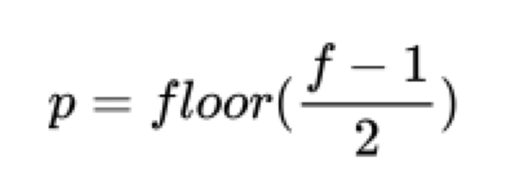

In [ ]:
ver_imag("/content/imagen5.png")

## Entendiendo los strides en una CNN
Otra cosa que debemos discutir aquí es que nos movimos de lado 1 píxel a la vez. Este valor es un parámetro configurable conocido como stride. Ayuda a determinar cómo debe capturarse la superposición o la transición de un píxel a otro.
Así es como podemos generalizar la ecuación para acomodar diferentes strides utilizando el stride como un parámetro.
Supongamos que aplicamos un stride de s al realizar convoluciones. Aquí, nuestra matriz de salida usará la siguiente ecuación:
$$(\frac{n+2p-f}{s}+1)*(\frac{n+2p-f}{s}+1)$$

Junto con las convoluciones, estamos utilizando una capa de pooling y una capa completamente conectada. A continuación, descubriremos cómo funcionan estas capas y qué sucede después de que los filtros se aplican a los datos de entrada.

## ¿Qué es el pooling?
En la operación de convolución, lo que tratamos de capturar fueron características o patrones en los datos utilizando algunos filtros. El objetivo es mantener la computación lo más mínima posible mientras se captura la mayor cantidad de información posible. Por lo tanto, en todo momento, debemos intentar mantener solo la información necesaria que pueda describir la característica que se ha capturado. Esto se realiza mediante capas de pooling. La operación de pooling ayuda a reducir la resolución de los datos para que solo se conserve la información relevante. Dejamos de lado la mayoría de la información no deseada, de modo que se requiera una computación mínima. Como resultado, esto ayuda a prevenir el sobreajuste (overfitting). Otra cosa que puede que hayas notado es que, incluso si los datos se desplazan un poco, el pooling nos permite capturar la información que necesitamos, independientemente de dónde esté ubicada la característica en los datos. Esta propiedad se conoce como invariancia espacial.

Ahora, intentemos entender algunas de las técnicas de pooling más utilizadas. Existen varios tipos de pooling que se pueden realizar. Tomemos una matriz y veamos cómo se pueden aplicar las diferentes estrategias de pooling a ella. Tomaremos un stride de 2:

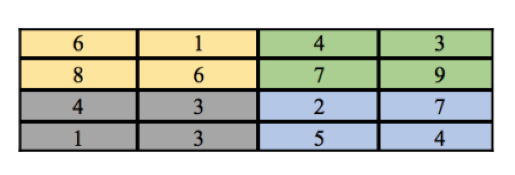

In [ ]:
ver_imag("/content/imagen6.png")

Max pooling: Esta es la técnica de pooling más común que se puede aplicar. En el max pooling, se toma el valor máximo dentro de una ventana de filtro. El valor máximo que se obtiene para nuestra matriz con un stride de 2 sería el siguiente:

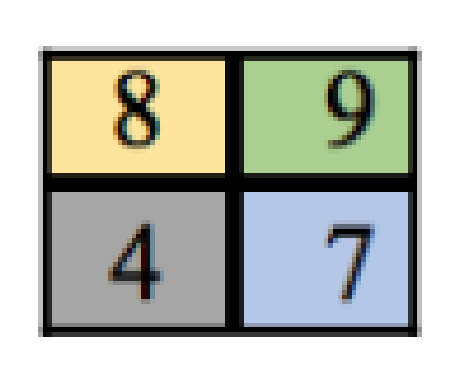

In [ ]:
ver_imag("/content/imagen7.png")

Average pooling: Esta técnica, como su nombre indica, toma el promedio dentro de los bloques de 2 x 2. Veamos cuáles serían los resultados del average pooling en la matriz:

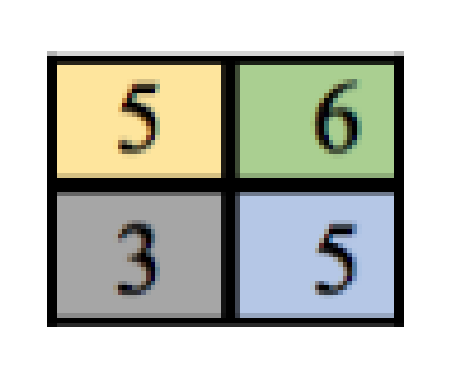

In [ ]:
ver_imag("/content/imagen8.png")

Sum pooling: La siguiente técnica que discutiremos es el sum pooling, donde simplemente tomamos la suma de los valores dentro del filtro. La siguiente matriz muestra el resultado que se obtiene al utilizar sum pooling. El sum pooling es el método de pooling menos utilizado entre los que discutiremos:

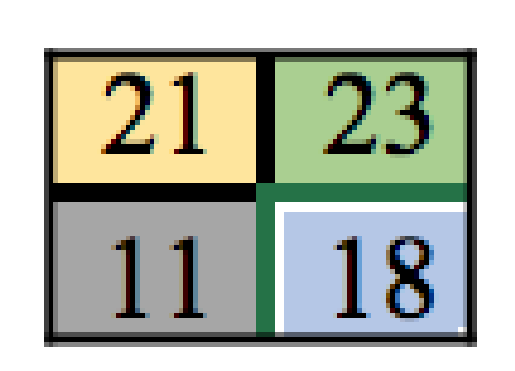

In [ ]:
ver_imag("/content/imagen9.png")

## La capa completamente conectada
Las capas de convolución y pooling nos ayudan a extraer y refinar características de las entradas que la red recibe. Necesitamos algo que realmente pueda clasificar o hacer algo con estas características. Los resultados después de realizar las convoluciones y el pooling se aplanan en un vector que  alimenta a una red neuronal. Después de enviar el vector de características a través de una red neuronal que posiblemente contenga varias capas y funciones de activación, obtenemos los resultados finales de clasificación.

Hasta ahora, hemos entendido cómo una CNN captura características de las imágenes, pero ¿cómo tiene sentido todo esto con datos de texto?

## Detección de sarcasmo en texto usando CNNs
Las convoluciones que hemos visto hasta ahora capturan relaciones espaciales en los datos como imágenes específicas. Sin embargo, el texto tiene más de una relación secuencial, donde las palabras cercanas a una dada aportan más información para esa palabra en particular que cualquier palabra que aparezca en una línea justo por encima de ellas. Por lo tanto, para los datos de texto, observamos relaciones espaciales unidimensionales y aprovechamos la capa Conv1D para este propósito. Esto es similar a trabajar con n-grams, donde habría superposiciones en las ventanas consecutivas de n-grams. El valor de n sería especificado por el parámetro de tamaño del kernel que proporcionas como entrada a la capa Conv1D.
El siguiente diagrama nos ayudará a entender cómo las CNNs pueden ser utilizadas para encontrar patrones en datos de texto.

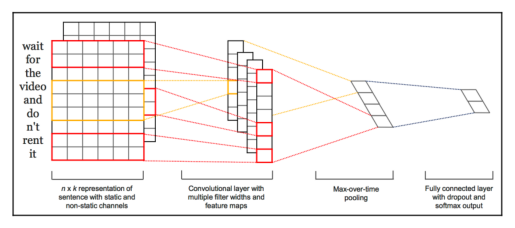

In [ ]:
ver_imag("/content/imagen10.png")

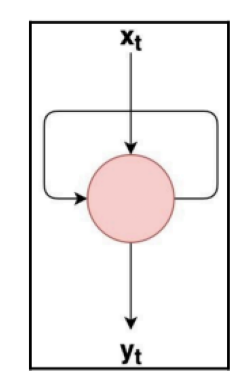

In [ ]:
ver_imag("/content/imagen11.png")

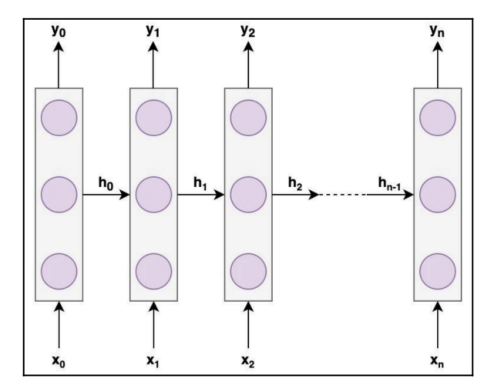

In [ ]:
ver_imag("/content/iamgen12.png")

El diagrama anterior muestra cómo los word embeddings se envían como entradas a la capa de convolución, que contiene múltiples filtros. Esto es seguido por max pooling y, finalmente, se aplica la capa completamente conectada y dropout con la función de activación adecuada. Usaremos una arquitectura similar en nuestro estudio de detección de sarcasmo.
Ahora que hemos comprendido las convoluciones y cómo capturan características, estamos bien preparados para usarlas para realizar análisis de texto.

La detección de sarcasmo es un gran desafío en el procesamiento de lenguaje natural (NLP) en el mundo actual, desde los medios impresos hasta los comentarios, entre otros. Intentemos usar las CNNs para detectar sarcasmo en el texto.

1 - importar las diversas bibliotecas que utilizaremos.

In [ ]:
import pandas as pd
import numpy as np
import re
import json
import gensim
import math
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import KeyedVectors
import keras
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D
import h5py

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
pip install gensim

In [ ]:
 #Continue with loading the model:
import gensim.downloader as api
model = api.load('word2vec-google-news-300')
#model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

KeyboardInterrupt: 

2 - Leer los datos

In [ ]:
import zipfile

# Nombre del archivo ZIP ya cargado
zip_path = "/content/Sarcasm_Headlines_Dataset_v2.zip"

# Listar y extraer los archivos
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Lista los archivos dentro del ZIP
    archivos = zip_ref.namelist()
    print("Archivos en el ZIP:", archivos)

    # Extraer todos los archivos en el directorio actual
    zip_ref.extractall()
    print("Archivos extraídos en el directorio actual.")


In [ ]:
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

In [ ]:
data = list(parse_data('/content/Sarcasm_Headlines_Dataset_v2.json'))


3 - Entender la data

La salida anterior muestra cinco filas de los datos. Nuestros datos constan de tres columnas:

**headline** que contiene texto sarcástico y no sarcástico.
**is_sarcastic**, que es la variable de clase. Nos indica si un titular es sarcástico o no.
**article_link**, que contiene el enlace al artículo original del titular.



In [ ]:
df= pd.DataFrame(data)

4 - Limpiemos y preprocesemos nuestros datos utilizando la misma pipeline que hemos utilizado a lo largo de este libro. Los detalles se pueden encontrar en el Capítulo 3, Construyendo tu Vocabulario NLP. Aquí, realizamos lo siguiente:

* Eliminar caracteres especiales.
* Mantener solo datos alfanuméricos.
* Eliminar stopwords
* Lematizar nuestros datos
* 4Realizar case-folding en los datos:

In [ ]:
def text_clean(corpus):
    '''
    Purpose : Function to keep only alphabets, digits and certain words (punctuations, qmarks, tabs etc. removed)

    Input : Takes a text corpus, 'corpus' to be cleaned along with a list of words, 'keep_list', which have to be retained
            even after the cleaning process

    Output : Returns the cleaned text corpus

    '''
    cleaned_corpus = pd.Series()
    for row in corpus:
        qs = []
        for word in row.split():
            p1 = re.sub(pattern='[^a-zA-Z0-9]',repl=' ',string=word)
            p1 = p1.lower()
            qs.append(p1)
        #cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
        cleaned_corpus = pd.concat([cleaned_corpus,pd.Series(' '.join(qs))])
    return cleaned_corpus


In [ ]:
def stopwords_removal(corpus):
    stop = set(stopwords.words('english'))
    corpus = [[x for x in x.split() if x not in stop] for x in corpus]
    return corpus

In [ ]:
def lemmatize(corpus):
    lem = WordNetLemmatizer()
    corpus = [[lem.lemmatize(x, pos = 'v') for x in x] for x in corpus]
    return corpus

In [ ]:
def stem(corpus, stem_type = None):
    if stem_type == 'snowball':
        stemmer = SnowballStemmer(language = 'english')
        corpus = [[stemmer.stem(x) for x in x] for x in corpus]
    else :
        stemmer = PorterStemmer()
        corpus = [[stemmer.stem(x) for x in x] for x in corpus]
    return corpus

In [ ]:
def preprocess(corpus, cleaning = True, stemming = False, stem_type = None, lemmatization = False, remove_stopwords = True):

    '''
    Purpose : Function to perform all pre-processing tasks (cleaning, stemming, lemmatization, stopwords removal etc.)

    Input :
    'corpus' - Text corpus on which pre-processing tasks will be performed

    'cleaning', 'stemming', 'lemmatization', 'remove_stopwords' - Boolean variables indicating whether a particular task should
                                                                  be performed or not
    'stem_type' - Choose between Porter stemmer or Snowball(Porter2) stemmer. Default is "None", which corresponds to Porter
                  Stemmer. 'snowball' corresponds to Snowball Stemmer

    Note : Either stemming or lemmatization should be used. There's no benefit of using both of them together

    Output : Returns the processed text corpus

    '''
    if cleaning == True:
        corpus = text_clean(corpus)

    if remove_stopwords == True:
        corpus = stopwords_removal(corpus)
    else :
        corpus = [[x for x in x.split()] for x in corpus]

    if lemmatization == True:
        corpus = lemmatize(corpus)


    if stemming == True:
        corpus = stem(corpus, stem_type)

    corpus = [' '.join(x) for x in corpus]


    return corpus

In [ ]:
head_lines= preprocess(df['headline'], lemmatization = True, remove_stopwords = False)

5 ## Cargando el modelo Word2Vec y vectorizando nuestros datos


Primero, convertiremos el texto en números utilizando una técnica de embedding que ya hemos discutido.
Usamos Word2Vec para obtener las representaciones vectoriales de nuestros datos. Para esto, utilizaremos el modelo Word2Vec preentrenado.

In [ ]:
#!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
#!gunzip GoogleNews-vectors-negative300.bin.gz

In [ ]:

# Continue with loading the model:
#import gensim.downloader as api
#model = api.load('word2vec-google-news-300')
#model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

6 - En los próximos pasos, estaremos enviando los vectores de palabras, cada uno de tamaño 300, a nuestro modelo CNN. Sin embargo, para eso, las dimensiones de nuestros datos deben ser estandarizadas. Dado que nuestros datos provienen de titulares, los estandarizaremos para que tengan una longitud de 10. Si alguno de los titulares contiene más de 10 caracteres, se realizarán subsampling para mantener las representaciones vectoriales de los primeros 10 caracteres. Si algún titular contiene menos de 10 caracteres, los rellenaremos con ceros para que tengan vectores con valores de 0.

In [ ]:
MAX_LEN =10
VECTOR_SIZE=300

7 - Ahora, definamos un fragmento de código que convertirá los titulares preprocesados en sus respectivos vectores y también rellenará o realizará subsampling de los datos según si el tamaño de los datos es mayor o menor que la longitud máxima que hemos definido:

In [ ]:
def vectorize_data(data):
    vectors = []
    padding_vector = [0.0]*VECTOR_SIZE # rellenar con ceros

    for i, data_point in enumerate(data):
      data_point_vectors = [] #lista vacia
      count= 0 #contando desde cero
      tokens = data_point.split()
      for token in tokens:
        if count >= MAX_LEN:
          break
        if token in model:
          data_point_vectors.append(model[token]) #si la palabra está en el modelo saca la posición en el modelo
          count += 1

      if len(data_point_vectors) < MAX_LEN: # si la longitud es menor rellena de ceros
         to_fill = MAX_LEN - len(data_point_vectors)
         for _ in range(to_fill):
           data_point_vectors.append(padding_vector)

      vectors.append(data_point_vectors)

    return vectors


In [ ]:
vectorized_headlines = vectorize_data(head_lines)

TypeError: argument of type 'Sequential' is not iterable

8 - Agreguemos una pequeña validación para asegurar que los 10 vectores estén presentes para cada titular, tal como se define en el parámetro MAX_LENGTH

Debemos dividir nuestros datos en conjuntos de entrenamiento y prueba. Usaremos el siguiente fragmento de código para hacerlo. También podemos verificar el tamaño de cada componente utilizando una simple instrucción print

In [ ]:
train_div = math.floor(0.7 * len(vectorized_headlines))


In [ ]:
train_div

20033

In [ ]:
X_train = vectorized_headlines[:train_div]
X_test = vectorized_headlines[train_div:]
y_train = df['is_sarcastic'][:train_div]
y_test = df['is_sarcastic'][train_div:]

In [ ]:
X_train = np.reshape(X_train, (len(X_train), MAX_LEN, VECTOR_SIZE))
X_test = np.reshape(X_test, (len(X_test), MAX_LEN, VECTOR_SIZE))
y_train = np.array(y_train)
y_test = np.array(y_test)

Necesitamos reestructurar nuestros datos para convertirlos en la forma esperada por nuestro modelo CNN.

## Construcción del modelo CNN

Ahora que tenemos nuestros datos vectorizados listos, pasemos a la parte de la red neuronal convolucional (CNN). Comenzamos definiendo los hiperparámetros de nuestra red:

In [ ]:
FILTERS=8
KERNEL_SIZE=3
HIDDEN_LAYER_1_NODES=10
HIDDEN_LAYER_2_NODES=5
DROPOUT_PROB=0.35
NUM_EPOCHS=10
BATCH_SIZE=50



## Hemos especificado los siguientes hiperparámetros:

* El número de filtros.
* El tamaño del kernel, que indica la cantidad de tokens en el texto que analizaremos.
* El número de nodos que se usarán en cada una de las capas ocultas.
* El dropout, que indica el porcentaje de nodos que se desactivarán de forma aleatoria.
* El número de épocas o la cantidad de veces que procesaremos todos los datos.
* El tamaño del lote (batch size), que especifica la cantidad de titulares vectorizados que se ingresarán al modelo en cada lote.

Ahora, definamos nuestra capa convolucional

In [ ]:
model = Sequential()

model.add(Conv1D(FILTERS,
                 KERNEL_SIZE,
                 padding='same',
                 strides=1,
                 activation='relu',
                 input_shape = (MAX_LEN, VECTOR_SIZE)))
model.add(GlobalMaxPooling1D())
model.add(Dense(HIDDEN_LAYER_1_NODES, activation='relu'))
model.add(Dropout(DROPOUT_PROB))
model.add(Dense(HIDDEN_LAYER_2_NODES, activation='relu'))
model.add(Dropout(DROPOUT_PROB))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 10, 8)               │           7,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 8)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │              90 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,359 (28.75 KB)

 Trainable params: 7,359 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
training_history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5350 - loss: 0.6816
Epoch 2/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7173 - loss: 0.5743
Epoch 3/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7702 - loss: 0.5040
Epoch 4/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7982 - loss: 0.4506
Epoch 5/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8140 - loss: 0.4331
Epoch 6/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8272 - loss: 0.4084
Epoch 7/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8347 - loss: 0.3952
Epoch 8/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8547 - loss: 0.3682
Epoch 9/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8597 - loss: 0.3534
Epoch 10/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8684 - loss: 0.3403


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8077


In [ ]:
head_lines

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep totally nail why congress be fall short on gender racial equality',
 'eat your veggies 9 deliciously different recipes',
 'inclement weather prevent liar from get to work',
 'mother come pretty close to use word stream correctly',
 'my white inheritance',
 '5 ways to file your tax with less stress',
 'richard branson s global warm donation nearly as much as cost of fail balloon trip',
 'shadow government get too large to meet in marriott conference room b',
 'lot of parent know this scenario',
 'this lesbian be consider a father in indiana and an amaze one at that',
 'amanda peet tell her daughter sex be a special hug',
 'what to know regard current treatments for ebola',
 'chris christie suggest hillary clinton be to blame for boko haram s kidnap of hundreds of schoolgirls',
 'ford develop new suv that run purely on gasoline',
 'uber ceo travis kalanick step down from trump economic advisory council',
 'area b

Talller: Haga la predicciòn sobre 30 regsitros del conjunto de datos original

In [ ]:
sample_indices = np.random.choice(len(df), 30, replace=False)  # Randomly select 30 indices
sample_headlines = df['headline'][sample_indices]  # Get the headlines corresponding to the indices

In [ ]:
sample_headlines_df = pd.DataFrame(sample_headlines)

In [ ]:
sample_preprocessed = preprocess(sample_headlines_df['headline'], lemmatization=True, remove_stopwords=False)

In [ ]:
sample_vectorized = vectorize_data(sample_preprocessed)

TypeError: argument of type 'Sequential' is not iterable

In [ ]:
sample_headlines_vectorized = np.reshape(sample_vectorized, (len(sample_headlines_vectorized), MAX_LEN, VECTOR_SIZE))


In [ ]:
predicted_labels = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

In [ ]:
for i in range(30):
    print(f"Headline: {sample_headlines.iloc[i]}")
    print(f"Predicted Label: {predicted_labels[i][0]}")  # 0: Non-sarcastic, 1: Sarcastic
    print("-" * 20)